In [313]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [314]:
# Read data in a list.
words = open('names.txt', 'r').read().splitlines()
print(f"Total amount of words: {len(words)}")

Total amount of words: 32033


In [315]:
# Build the vocabulary of characters and mappings to/from integers.
chars = sorted(list(set(''.join(words))))
stoi = {ch: ix + 1 for ix, ch in enumerate(chars)}
stoi['.'] = 0
itos = {ix: ch for ch, ix in stoi.items()}

In [316]:
def plot_2d_characters(C: torch.tensor, size: int = 8) -> None:
    """
    Given a look-up table C of 2D character representations plot them on the grid.
    Args:
        C(torch.tensor, shape=[num_characters, 2]): Look-up table.
        size(int)                                 : Size of the plot.
    """
    vowels = ['a', 'e', 'i', 'o', 'u']  # list of all vowels in alphabet
    colors = ['red' if itos[ch] in vowels else 'blue' for ch in range(C.shape[0])]  # color vowels red
    colors[stoi['.']] = 'green'  # color '.' token green

    plt.figure(figsize=(size, size))
    plt.scatter(C[:, 0].data, C[:, 1].data, s=200, c=colors)
    for i in range(C.shape[0]):
        plt.text(C[i, 0].data, C[i, 1].data, itos[i], ha='center', va='center', color='white')
    plt.grid('minor')

In [317]:
def build_dataset(words: list[str], context_size: int = 3, logging: bool = False) -> tuple[torch.tensor]:
    """
    Given an list of string words, creates input and output targets.
    Args:
        words(list[int], shape=[n]): List of all words to sample examples from.
        context_size(int)          : How many characters are considered for prediction.
        logging(bool)              : Whether to print builded examples or not.
    Returns:
        X(torch.tensor, shape=[m, contex size]): Input tensor, where m is number of examples.
        Y(torch.tensor, shape=[m])             : Target tensor, where m is number of examples.
    """
    X, Y = [], []
    for word in words:
        context = [0] * context_size
        for ch in word + '.':
            X.append(context)
            Y.append(stoi[ch])
            context = context[1:] + [stoi[ch]]
    X, Y = torch.tensor(X).cuda(), torch.tensor(Y).cuda()
    if logging:
        print(f'Input: {X.shape}, Output: {Y.shape}')
    return X, Y

---

In [358]:
# Model's hyperparameters
chs_amt = len(stoi)             # characters amount (27)
repr_dim = 10                    # characters representation deimensions 
cnx_size = 4                    # contex_size / characters considered for prediction 
ipt_size = repr_dim * cnx_size  # input size of a single example
W1_ns = 100                     # Amount of neurons in the first layer
W2_ns = 100                     # Amount of neurons in the second layer

In [359]:
import random
random.seed(13)
random.shuffle(words)
n1 = int(len(words) * 0.8)
n2 = int(len(words) * 0.9)

# Split data in Build, Development and Test sets.
Xtr, Ytr = build_dataset(words[:n1], cnx_size, True)
Xdev, Ydev = build_dataset(words[n1:n2], cnx_size, True)
Xte, Yte = build_dataset(words[n2:], cnx_size, True)

Input: torch.Size([182719, 4]), Output: torch.Size([182719])
Input: torch.Size([22686, 4]), Output: torch.Size([22686])
Input: torch.Size([22741, 4]), Output: torch.Size([22741])


In [360]:
# Initialize model
g = torch.Generator().manual_seed(13)
C = torch.randn(size=[chs_amt, repr_dim], generator=g).cuda()
W1 = torch.randn([ipt_size, W1_ns], generator=g).cuda()
b1 = torch.randn([W1_ns], generator=g).cuda()

W2 = torch.randn([W1_ns, W2_ns], generator=g).cuda() 
b2 = torch.randn([W2_ns], generator=g).cuda()

W3 = torch.randn([W2_ns, chs_amt], generator=g).cuda() 
b3 = torch.randn([chs_amt], generator=g).cuda()

parameters = [C, W1, b1, W2, b2, W3, b3]
tot_prms = sum(p.nelement() for p in parameters)  # total amount of parameters in a model
total_ws = sum(w.nelement() for w in [W1, W2, W3])  # total amount of W parameters in a model
# Tell torch to compute gradients for created parameters.
for p in parameters:
    p.requires_grad = True
print(tot_prms)
[p.shape for p in parameters]

17197


[torch.Size([27, 10]),
 torch.Size([40, 100]),
 torch.Size([100]),
 torch.Size([100, 100]),
 torch.Size([100]),
 torch.Size([100, 27]),
 torch.Size([27])]

In [361]:
"""Requires model and C-table initialization! Modifies global parameters!"""
def forward_pass(ipt_exmps: torch.tensor, tgt_exmps: torch.tensor) -> torch.tensor:
    """
    Given input parameters, input and target examples performs a forward pass and returns loss.
    Args:
        ipt_exmps(torch.tensor, shape=[m, ipt_size]): Input tensor, m - number of examples.
        tgt_exmps(torch.tensor, shape=[m])          : Target tensor, m - number of examples.
    Returns:
        loss(torch.tensor): evaluated loss.
    """
    emb = C[ipt_exmps]
    out1 = torch.tanh(emb.view(-1, ipt_size) @ W1 + b1)
    out2 = torch.tanh(out1 @ W2 + b2)
    logits = out2 @ W3 + b3

    reg = (((W1**2).sum() + (W2**2).sum() + (W3**2).sum()) / total_ws)
    
    loss = F.cross_entropy(logits, tgt_exmps) + 0.75 * reg
    return loss

In [362]:
# Place for tracking:
lri = []
lossi = []
stepi = []

usteps = []
trlosses = []
devlosses = []

In [363]:
# Learning hyperparameters
iters_num = 200000                 # number of iterations
lr = 0.1                     # learning rate
batch_size = 32               # size of the mini-batch
log_loss_step = False          # pring loss at each gradient step
upd_step = 3000
log_upd = True        

In [364]:
for i in range(iters_num):
    if (i+1) % upd_step == 0:
        lr *= 0.97
        # Limit learning rate decrease
        if lr < 0.0001:
            lr = 0.0001

        batch_size = int(batch_size*1.02)
        # Limit batch size growth
        if batch_size > 1024:
            batch_size = 1024

        trloss = forward_pass(Xtr, Ytr)
        devloss = forward_pass(Xdev, Ydev)
        trlosses.append(trloss)
        devlosses.append(devloss)
        usteps.append(i)
        if log_upd:
            print(f'{i=} | {lr=:0.5f} | {batch_size=} | {trloss=:0.5f} | {devloss=:0.5f}')
    
    """Mini-batch construct"""
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    
    """Forward pass"""
    loss = forward_pass(Xtr[ix], Ytr[ix])
    if log_loss_step:
        print(loss.item())
    
    """Backward pass"""
    for p in parameters:
        p.grad = None
    loss.backward()
    
    """Update"""
    for p in parameters:
        p.data += -lr * p.grad
    
    """Track stats"""
    # lri.append(lre[i])
    lossi.append(loss.item())
    stepi.append(i)


i=2999 | lr=0.09700 | batch_size=32 | trloss=3.23540 | devloss=3.23184
i=5999 | lr=0.09409 | batch_size=32 | trloss=3.19487 | devloss=3.18877
i=8999 | lr=0.09127 | batch_size=32 | trloss=3.06958 | devloss=3.07002
i=11999 | lr=0.08853 | batch_size=32 | trloss=3.02948 | devloss=3.03319
i=14999 | lr=0.08587 | batch_size=32 | trloss=3.01492 | devloss=3.01994
i=17999 | lr=0.08330 | batch_size=32 | trloss=2.93374 | devloss=2.94009
i=20999 | lr=0.08080 | batch_size=32 | trloss=2.92839 | devloss=2.93643
i=23999 | lr=0.07837 | batch_size=32 | trloss=2.85952 | devloss=2.86634
i=26999 | lr=0.07602 | batch_size=32 | trloss=2.85725 | devloss=2.86925
i=29999 | lr=0.07374 | batch_size=32 | trloss=2.80220 | devloss=2.80880
i=32999 | lr=0.07153 | batch_size=32 | trloss=2.81528 | devloss=2.82311
i=35999 | lr=0.06938 | batch_size=32 | trloss=2.74709 | devloss=2.75939
i=38999 | lr=0.06730 | batch_size=32 | trloss=2.83164 | devloss=2.84192
i=41999 | lr=0.06528 | batch_size=32 | trloss=2.70569 | devloss=2.7

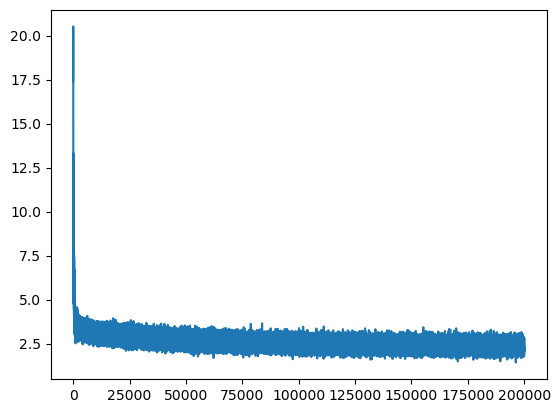

In [365]:
plt.plot(stepi, lossi)

In [371]:
train_loss = forward_pass(Xtr, Ytr) - (((W1**2).sum() + (W2**2).sum() + (W3**2).sum()) / total_ws) * 0.75
dev_loss = forward_pass(Xdev, Ydev) - (((W1**2).sum() + (W2**2).sum() + (W3**2).sum()) / total_ws) * 0.75
print(f"train: {train_loss}\ndevop: {dev_loss}")

train: 2.185429096221924
devop: 2.2088942527770996


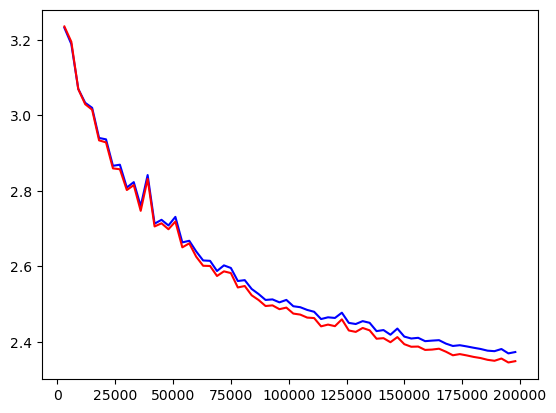

In [369]:
plt.plot(usteps, [loss.item() for loss in devlosses], c='blue')
plt.plot(usteps, [loss.item() for loss in trlosses], c='red')

In [370]:
# Sampling from the model!
cudag = torch.Generator(device='cuda').manual_seed(13)
samples = []
num_samples = 100
for i in range(num_samples):
    context = [0] * cnx_size
    sample = ''
    while True:
        x = C[context].view(-1, cnx_size * repr_dim)
        out1 = torch.tanh(x @ W1 + b1)
        out2 = torch.tanh(out1 @ W2 + b2)
        logits = out2 @ W3 + b3
        counts = torch.exp(logits)
        probs = counts / torch.sum(counts)
        guess = torch.multinomial(probs, 1, True, generator=cudag).item()
        sample += itos[guess]
        context = context[1:] + [guess]
        if guess == 0:
            break
    samples.append(sample[:-1])

samples


['morrin',
 'mafi',
 'hola',
 'kemmi',
 'saghon',
 'auaz',
 'jomy',
 'bewbatte',
 'rambhovince',
 'hahc',
 'losqunky',
 'oooy',
 'jenliston',
 'mona',
 'zanolin',
 'arari',
 'maksay',
 'kishauj',
 'jainia',
 'nainah',
 'jella',
 'hilen',
 'mephan',
 'korfin',
 'afrrynn',
 'tylen',
 'naeryna',
 'paidjeren',
 'jefiya',
 'aunganan',
 'bemariyah',
 'abunia',
 'rary',
 'jose',
 'maghlloya',
 'yahah',
 'manlyn',
 'mane',
 'milya',
 'pasbusta',
 'zari',
 'mara',
 'edli',
 'jisson',
 'rahis',
 'amoymsekecle',
 'darelsarayana',
 'glandy',
 'dvie',
 'jicielniy',
 'maroiri',
 'hani',
 'loy',
 'myra',
 'yoyda',
 'luan',
 'amalandtue',
 'kenis',
 'jahson',
 'alevestiano',
 'olip',
 'leztel',
 'jiis',
 'aki',
 'analie',
 'aszon',
 'namaa',
 'taka',
 'amilaon',
 'mahalia',
 'meka',
 'jana',
 'anarey',
 'raylinn',
 'anam',
 'aret',
 'ralandah',
 'amari',
 'frylah',
 'yuvann',
 'acam',
 'likt',
 'vityadi',
 'trek',
 'tmeni',
 'kaelia',
 'navua',
 'keyvam',
 'awaine',
 'bondin',
 'wyna',
 'ronni',
 'aan